# **Neural Network to predict Healthcare Costs**


Import and Load Libraries

In [ ]:
!pip install tabulate tensorflow

import numpy as np
import pandas as pd
import cupy as cp
import cudf
import cuml

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Files

In [ ]:
# Define the correct folder path
base_path = "/content/drive/MyDrive/Capstone Project/Data/"

# Load feature datasets
X_train = pd.read_csv(base_path + "features_train.csv")
X_test = pd.read_csv(base_path + "features_test.csv")

# Load cost datasets (y values) and flatten them
y_train = pd.read_csv(base_path + "cost_train.csv").values.ravel()
y_test = pd.read_csv(base_path + "cost_test.csv").values.ravel()

# Verify dataset shape
print(f"Training Features: {X_train.shape}, Training Labels: {y_train.shape}")
print(f"Test Features: {X_test.shape}, Test Labels: {y_test.shape}")

Training Features: (1492974, 138), Training Labels: (1492974,)
Test Features: (639847, 138), Test Labels: (639847,)


In [ ]:
# Convert to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values

Train Neuaral Network

In [ ]:
# Use the Input layer as the first layer
input_layer = Input(shape=(X_train.shape[1],))
nn_model = Sequential([
    input_layer,
    Dense(128, activation='relu'),
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer - single neuron for regression
])

In [ ]:
# Configure the model
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'  # Mean squared error for regression
)

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
# Train the model
history = nn_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=500,
    batch_size=256,  # Adjust batch size based on your GPU memory
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.2647 - val_loss: 0.1834
Epoch 2/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1780 - val_loss: 0.1706
Epoch 3/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1709 - val_loss: 0.1699
Epoch 4/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1675 - val_loss: 0.1670
Epoch 5/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1654 - val_loss: 0.1698
Epoch 6/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1625 - val_loss: 0.1664
Epoch 7/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1626 - val_loss: 0.1663
Epoch 8/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1617 - val_loss: 0.1652
Epoch 9/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1596 - val_loss: 0.1628
Epoch 10/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1592 - val_loss: 0.1591
Epoch 11/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1588 - val_loss: 0.1610
Epoch 12

In [ ]:
# Make predictions
y_pred = nn_model.predict(X_test).flatten()

19996/19996 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step


In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
# Print results
print(f"Neural Network (MLPRegressor) Model Performance:")
print(tabulate([
    ["MSE", f"{mse:.2f}"],
    ["RMSE", f"{rmse:.2f}"],
    ["R²", f"{r2:.4f}"]],
    headers=["Metric", "Value"],
    tablefmt="rounded_outline"))

Neural Network (MLPRegressor) Model Performance:
╭──────────┬─────────╮
│ Metric   │   Value │
├──────────┼─────────┤
│ MSE      │  0.15   │
│ RMSE     │  0.39   │
│ R²       │  0.8454 │
╰──────────┴─────────╯


Feature Selection

In [ ]:
import gc

# Force garbage collection before starting
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# Convert inputs to numpy arrays
X_np = X_test.copy()
if hasattr(X_np, 'to_numpy'):
    X_np = X_np.to_numpy()
if hasattr(y_test, 'to_numpy'):
    y_np = y_test.to_numpy()
else:
    y_np = y_test

if y_np.ndim == 2 and y_np.shape[1] == 1:
    y_np = y_np.flatten()

In [ ]:
# Get feature names
feature_names = X_test.columns

In [ ]:
# Parameters
n_repeats = 5
batch_size = 256  # Your large batch size

# Get baseline score
baseline_preds = nn_model.predict(X_np, batch_size=batch_size)

if baseline_preds.ndim == 2 and baseline_preds.shape[1] == 1:
    baseline_preds = baseline_preds.flatten()

# Print baseline score
baseline_score = mean_squared_error(y_np, baseline_preds)
print(f"Baseline MSE: {baseline_score:.6f}")

# Clear memory after baseline prediction
del baseline_preds
gc.collect()
tf.keras.backend.clear_session()

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Baseline MSE: 0.154424


In [ ]:
# Process one feature at a time
importances = []

for feature_idx, col in enumerate(feature_names):
    print(f"Processing feature {feature_idx+1}/{len(feature_names)}: {col}")
    feature_importance = []

    for i in range(n_repeats):
        # Create a copy of the data
        X_permuted = X_np.copy()

        # Permute a single column
        permuted_values = np.random.permutation(X_permuted[:, feature_idx])
        X_permuted[:, feature_idx] = permuted_values

        # Make prediction
        preds = nn_model.predict(X_permuted, batch_size=batch_size)

        if preds.ndim == 2 and preds.shape[1] == 1:
            preds = preds.flatten()

        # Calculate importance
        permuted_score = mean_squared_error(y_np, preds)
        importance = permuted_score - baseline_score
        feature_importance.append(importance)

        # Clean up memory immediately
        del X_permuted
        del preds
        gc.collect()
        tf.keras.backend.clear_session()

    # Calculate mean importance for this feature
    mean_importance = np.mean(feature_importance)
    importances.append((col, mean_importance))
    print(f"  Importance: {mean_importance:.6f}")

    # Extra memory cleanup after each feature
    gc.collect()
    tf.keras.backend.clear_session()

# Create final DataFrame
feature_importance_df = pd.DataFrame(importances, columns=['Feature', 'Importance'])

Processing feature 1/138: Age Group
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
  Importance: 0.010909
Processing feature 2/138: Length of Stay
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
  Importance: 0.882602
Processing feature 3/138: Severity of Illness
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
  Importance: 0.012336
Processing feature 4/138: Risk of Mortality
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s

In [ ]:
# Make sure importances are positive (if needed)
if feature_importance_df['Importance'].min() < 0:
    feature_importance_df['Importance'] = feature_importance_df['Importance'].abs()

In [ ]:
# Sort by importance (higher values = more important)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Check for and remove duplicate features
if feature_importance_df['Feature'].duplicated().any():
    feature_importance_df = feature_importance_df.drop_duplicates(subset=['Feature'])

In [ ]:
# Calculate the cumulative importance
total_importance = feature_importance_df['Importance'].sum()
feature_importance_df['Normalized_Importance'] = feature_importance_df['Importance'] / total_importance
feature_importance_df['Cumulative_Importance'] = feature_importance_df['Normalized_Importance'].cumsum()

In [ ]:
# Define importance thresholds to evaluate
importance_thresholds = [0.95, 0.90, 0.85]
results = {}

# Evaluate models for different thresholds
for threshold in importance_thresholds:
    print(f"\nEvaluating threshold: {threshold}")

    # Select features based on cumulative importance threshold
    selected_features = feature_importance_df[feature_importance_df['Cumulative_Importance'] <= threshold]['Feature'].tolist()
    print(f"Selected {len(selected_features)} features ({len(selected_features)/len(X_train.columns):.1%} of original features)")

    # Free memory before creating feature subsets
    gc.collect()
    tf.keras.backend.clear_session()

    # Create subsets with selected features
    X_train_selected = X_train[selected_features].values
    X_test_selected = X_test[selected_features].values

    # Use the same Sequential model setup with the new input shape
    input_layer = Input(shape=(len(selected_features),))
    nn_model_selected = Sequential([
        input_layer,
        Dense(128, activation='relu'),
        Dropout(0.2),  # Add dropout for regularization
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer - single neuron for regression
    ])

    # Configure the model
    nn_model_selected.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse'  # Mean squared error for regression
    )

    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    # Train the model
    history = nn_model_selected.fit(
        X_train_selected, y_train,
        validation_split=0.1,
        epochs=500,
        batch_size=256,
        callbacks=[early_stopping],
        verbose=1
    )


    # Make predictions
    y_pred = nn_model_selected.predict(X_test_selected, batch_size=256).flatten()

    # Calculate metrics
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    r2_value = r2_score(y_test, y_pred)

    # Store results
    results[threshold] = {
        'n_features': len(selected_features),
        'features': selected_features,
        'mse': mse_value,
        'rmse': rmse_value,
        'r2': r2_value,
        'model': nn_model_selected  # Store the model object
    }

    # Clean up after each threshold evaluation
    del X_train_selected
    del X_test_selected
    del nn_model_selected
    gc.collect()
    tf.keras.backend.clear_session()


Evaluating threshold: 0.95
Selected 82 features (59.4% of original features)
Epoch 1/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2790 - val_loss: 0.1850
Epoch 2/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1884 - val_loss: 0.1847
Epoch 3/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1800 - val_loss: 0.1759
Epoch 4/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1760 - val_loss: 0.1772
Epoch 5/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1738 - val_loss: 0.1741
Epoch 6/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1712 - val_loss: 0.1703
Epoch 7/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1697 - val_loss: 0.1704
Epoch 8/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.1684 - val_loss: 0.1685
Epoch 9/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1678 - val_loss: 0.1700
Epoch 10/500
5249/5249 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1672 - val_loss: 0.1658
Epoch 11/500
5249/524

In [ ]:
# Print results
for threshold, metrics in results.items():
  print(tabulate([
      [f"Threshold: {threshold}"],
      [f"Number of Features: {metrics['n_features']}"],
      [f"MSE: {metrics['mse']:.2f}"],
      [f"RMSE: {metrics['rmse']:.2f}"],
      [f"R² Score: {metrics['r2']:.4f}"]],
      headers=["Metric", "Value"],
      tablefmt="rounded_outline"))

╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.95        │
│ Number of Features: 82 │
│ MSE: 0.16              │
│ RMSE: 0.40             │
│ R² Score: 0.8391       │
╰────────────────────────╯
╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.9         │
│ Number of Features: 60 │
│ MSE: 0.16              │
│ RMSE: 0.41             │
│ R² Score: 0.8355       │
╰────────────────────────╯
╭────────────────────────╮
│ Metric                 │
├────────────────────────┤
│ Threshold: 0.85        │
│ Number of Features: 44 │
│ MSE: 0.17              │
│ RMSE: 0.41             │
│ R² Score: 0.8289       │
╰────────────────────────╯


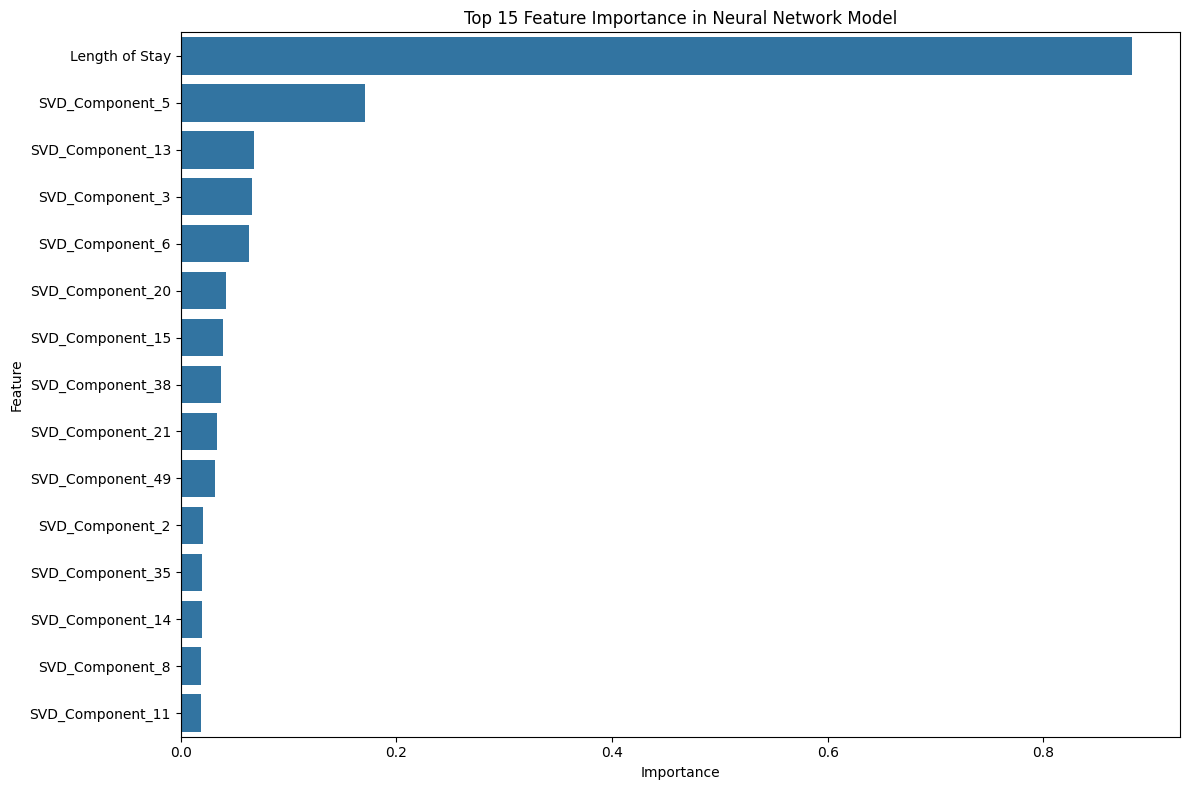

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Feature Importance in Neural Network Model')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

Save Model

In [ ]:
drive_path = "/content/drive/My Drive/Capstone Project/Code/Models/NeuralNetwork/nn_model.joblib"
joblib.dump(nn_model, drive_path)
print(f"Model saved to Google Drive: {drive_path}")